In [13]:
!pip install torch # framework
!pip install --upgrade reedsolo
!pip install --upgrade librosa
!pip install torchvision
#!pip install torchaudio 
#!pip install tensorboard
#!pip install soundfile
!pip install librosa==0.7.1

Requirement already up-to-date: reedsolo in /usr/local/lib/python3.6/dist-packages (1.5.4)
Processing /root/.cache/pip/wheels/ee/10/1e/382bb4369e189938d5c02e06d10c651817da8d485bfd1647c9/librosa-0.8.0-cp36-none-any.whl
  Found existing installation: librosa 0.7.1
    Uninstalling librosa-0.7.1:
      Successfully uninstalled librosa-0.7.1


Processing /root/.cache/pip/wheels/07/36/47/a9a4d151332cbdaec564500af9704a0ad862cf554dcf4bfda0/librosa-0.7.1-cp36-none-any.whl
  Found existing installation: librosa 0.8.0
    Uninstalling librosa-0.8.0:
      Successfully uninstalled librosa-0.8.0


In [2]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True) 
%cd /content/drive/My\ Drive/

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive


In [14]:
import numpy as np
import librosa
import librosa.display 
import datetime
import matplotlib.pyplot as plt
from torch.nn.functional import binary_cross_entropy_with_logits, mse_loss
from torchvision import datasets, transforms
from IPython.display import clear_output
import torchvision
from torchvision.datasets.vision import VisionDataset
from torch.optim import Adam
from tqdm import notebook
import torch
import os.path
import os
import gc
import sys
from PIL import ImageFile, Image
#from torchaudio import transforms as audiotransforms
#import torchaudio
#import soundfile 
#from IPython.display import Audio
import random


ImageFile.LOAD_TRUNCATED_IMAGES = True

In [4]:
epochs = 64
data_depth = 4
hidden_size = 32
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
LOAD_MODEL=True
#PATH='/content/drive/My Drive/myresults/model/DenseEncoder_DenseDecoder_0.041_2020-07-25_15:31:19.dat'
#PATH='/content/drive/My Drive/myresults/model/DenseEncoder_DenseDecoder_-0.003_2020-07-24_20:01:33.dat'
#PATH='/content/drive/My Drive/myresults/model/DenseEncoder_DenseDecoder_-0.022_2020-07-24_05:11:17.dat'
#PATH='/content/drive/My Drive/myresults/model/DenseEncoder_DenseDecoder_-0.041_2020-07-23_23:01:25.dat'
PATH='/content/drive/My Drive/myresults/model/DenseEncoder_DenseDecoder_0.042_2020-07-23_02:08:27.dat' ##Depth4Epoch64
#PATH='/content/drive/My Drive/myresults/model/DenseEncoder_DenseDecoder_0.005_2020-07-22_20:05:49.dat'
#PATH='/content/drive/My Drive/myresults/model/DenseEncoder_DenseDecoder_-0.019_2020-07-22_15:02:29.dat'
#PATH='/content/drive/My Drive/myresults/model/DenseEncoder_DenseDecoder_-0.020_2020-07-22_13:43:02.dat'
#PATH='/content/drive/My Drive/myresults/model/DenseEncoder_DenseDecoder_+0.048_2020-07-22_12:21:23.dat'
#PATH='/content/drive/My Drive/myresults/model/DenseEncoder_DenseDecoder_+0.017_2020-07-22_08:18:00.dat'

In [5]:
import torch
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
from math import exp

# -*- coding: utf-8 -*-

import zlib
from math import exp

import torch
from reedsolo import RSCodec
from torch.nn.functional import conv2d

rs = RSCodec(250)


def text_to_bits(text):
    """Convert text to a list of ints in {0, 1}"""
    return bytearray_to_bits(text_to_bytearray(text))


def bits_to_text(bits):
    """Convert a list of ints in {0, 1} to text"""
    return bytearray_to_text(bits_to_bytearray(bits))


def bytearray_to_bits(x):
    """Convert bytearray to a list of bits"""
    result = []
    for i in x:
        bits = bin(i)[2:]
        bits = '00000000'[len(bits):] + bits
        result.extend([int(b) for b in bits])

    return result


def bits_to_bytearray(bits):
    """Convert a list of bits to a bytearray"""
    ints = []
    for b in range(len(bits) // 8):
        byte = bits[b * 8:(b + 1) * 8]
        ints.append(int(''.join([str(bit) for bit in byte]), 2))

    return bytearray(ints)


def text_to_bytearray(text):
    """Compress and add error correction"""
    assert isinstance(text, str), "expected a string"
    x = zlib.compress(text.encode("utf-8"))
    x = rs.encode(bytearray(x))
    return x

def bytearray_to_text(x):
    """Apply error correction and decompress"""
    try:
      #print('1: ',x)
      text = rs.decode(x)[0]
      #print('2: ',x)
      text = zlib.decompress(text)
      #print('3: ',x)
      return text.decode("utf-8")
    except BaseException as e: 
      print(e)
      return False

def gaussian(window_size, sigma):
    gauss = torch.Tensor([exp(-(x - window_size//2)**2/float(2*sigma**2)) for x in range(window_size)])
    return gauss/gauss.sum()

def create_window(window_size, channel):
    _1D_window = gaussian(window_size, 1.5).unsqueeze(1)
    _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
    window = Variable(_2D_window.expand(channel, 1, window_size, window_size).contiguous())
    return window

def _ssim(img1, img2, window, window_size, channel, size_average = True):
    mu1 = F.conv2d(img1, window, padding = window_size//2, groups = channel)
    mu2 = F.conv2d(img2, window, padding = window_size//2, groups = channel)

    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1*mu2

    sigma1_sq = F.conv2d(img1*img1, window, padding = window_size//2, groups = channel) - mu1_sq
    sigma2_sq = F.conv2d(img2*img2, window, padding = window_size//2, groups = channel) - mu2_sq
    sigma12 = F.conv2d(img1*img2, window, padding = window_size//2, groups = channel) - mu1_mu2

    C1 = 0.01**2
    C2 = 0.03**2

    ssim_map = ((2*mu1_mu2 + C1)*(2*sigma12 + C2))/((mu1_sq + mu2_sq + C1)*(sigma1_sq + sigma2_sq + C2))

    if size_average:
        return ssim_map.mean()
    else:
        return ssim_map.mean(1).mean(1).mean(1)

class SSIM(torch.nn.Module):
    def __init__(self, window_size = 11, size_average = True):
        super(SSIM, self).__init__()
        self.window_size = window_size
        self.size_average = size_average
        self.channel = 1
        self.window = create_window(window_size, self.channel)

    def forward(self, img1, img2):
        (_, channel, _, _) = img1.size()

        if channel == self.channel and self.window.data.type() == img1.data.type():
            window = self.window
        else:
            window = create_window(self.window_size, channel)
            
            if img1.is_cuda:
                window = window.cuda(img1.get_device())
            window = window.type_as(img1)
            
            self.window = window
            self.channel = channel


        return _ssim(img1, img2, window, self.window_size, channel, self.size_average)

def ssim(img1, img2, window_size = 11, size_average = True):
    (_, channel, _, _) = img1.size()
    window = create_window(window_size, channel)
    
    if img1.is_cuda:
        window = window.cuda(img1.get_device())
    window = window.type_as(img1)
    
    return _ssim(img1, img2, window, window_size, channel, size_average)


In [6]:
import torch
from torch import nn
import numpy

class BasicEncoder(nn.Module):
    """
    The BasicEncoder module takes an cover image and a data tensor and combines
    them into a steganographic image.

    """
    def _name(self):
      return "BasicEncoder"

    def _conv2d(self, in_channels, out_channels):
        return nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=3,
            padding=1
        )

    def _build_models(self):
        self.conv1 = nn.Sequential(
            self._conv2d(3, self.hidden_size),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm2d(self.hidden_size),
        )
        self.conv2 = nn.Sequential(
            self._conv2d(self.hidden_size + self.data_depth, self.hidden_size),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm2d(self.hidden_size),
        )
        self.conv3 = nn.Sequential(
            self._conv2d(self.hidden_size, self.hidden_size),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm2d(self.hidden_size),
        )
        self.conv4 = nn.Sequential(
            self._conv2d(self.hidden_size, 3),
        )
        return self.conv1, self.conv2, self.conv3, self.conv4

    def __init__(self, data_depth, hidden_size):
        super().__init__()
        self.data_depth = data_depth
        self.hidden_size = hidden_size
        self._models = self._build_models()
        self.name = self._name()

    def forward(self, image, data):
        x = self._models[0](image)
        x_1 = self._models[1](torch.cat([x] + [data], dim=1))
        x_2 = self._models[2](x_1)
        x_3 = self._models[3](x_2)
        return x_3


class ResidualEncoder(BasicEncoder):
    def _name(self):
      return "ResidualEncoder"

    def forward(self, image, data):
        return image + super().forward(self, image, data)


class DenseEncoder(BasicEncoder):
    def _name(self):
      return "DenseEncoder"

    def _build_models(self):
        self.conv1 = super()._build_models()[0]
        self.conv2 = super()._build_models()[1]
        self.conv3 = nn.Sequential(
            self._conv2d(self.hidden_size * 2 +
                         self.data_depth, self.hidden_size),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm2d(self.hidden_size),
        )
        self.conv4 = nn.Sequential(
            self._conv2d(self.hidden_size * 3 + self.data_depth, 3)
        )

        return self.conv1, self.conv2, self.conv3, self.conv4

    def forward(self, image, data):
        x = self._models[0](image)
        x_list = [x]
        x_1 = self._models[1](torch.cat(x_list+[data], dim=1))
        x_list.append(x_1)
        x_2 = self._models[2](torch.cat(x_list+[data], dim=1))
        x_list.append(x_2)
        x_3 = self._models[3](torch.cat(x_list+[data], dim=1))
        x_list.append(x_3)
        return image + x_3


In [7]:
import torch
from torch import nn
#from torch.nn import Sigmoid
#from torch.distributions import Bernoulli


class BasicDecoder(nn.Module):
    """
    The BasicDecoder module takes an steganographic image and attempts to decode
    the embedded data tensor.

    Input: (N, 3, H, W)
    Output: (N, D, H, W)
    """
    def _name(self):
      return "BasicDecoder"

    def _conv2d(self, in_channels, out_channels):
        return nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=3,
            padding=1
        )

    def _build_models(self):
        self.conv1 = nn.Sequential(
            self._conv2d(3, self.hidden_size),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm2d(self.hidden_size),
        )
        self.conv2 = nn.Sequential(
            self._conv2d(self.hidden_size, self.hidden_size),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm2d(self.hidden_size),
        )
        self.conv3 = nn.Sequential(
            self._conv2d(self.hidden_size, self.hidden_size),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm2d(self.hidden_size),
        )
        self.conv4 = nn.Sequential(
            self._conv2d(self.hidden_size, self.data_depth),
            #nn.Sigmoid(),
        )

        return self.conv1, self.conv2, self.conv3, self.conv4

    def forward(self, image):
        x = self._models[0](image)
        x_1 = self._models[1](x)
        x_2 = self._models[2](x_1)
        x_3 = self._models[3](x_2)
        #x_4 = Bernoulli(x_3).sample()
        return x_3

    def __init__(self, data_depth, hidden_size):
        super().__init__()
        self.data_depth = data_depth
        self.hidden_size = hidden_size
        self._models = self._build_models()
        self.name = self._name()


class DenseDecoder(BasicDecoder):
    def _name(self):
      return "DenseDecoder"

    def _build_models(self):
        self.conv1 = super()._build_models()[0]
        self.conv2 = super()._build_models()[1]
        self.conv3 = nn.Sequential(
            self._conv2d(self.hidden_size * 2, self.hidden_size),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm2d(self.hidden_size)
        )
        self.conv4 = nn.Sequential(
            self._conv2d(self.hidden_size * 3, self.data_depth),
            #nn.Sigmoid(),
        )

        return self.conv1, self.conv2, self.conv3, self.conv4

    def forward(self, image):
        x = self._models[0](image)
        x_list = [x]
        x_1 = self._models[1](torch.cat(x_list, dim=1))
        x_list.append(x_1)
        x_2 = self._models[2](torch.cat(x_list, dim=1))
        x_list.append(x_2)
        x_3 = self._models[3](torch.cat(x_list, dim=1))
        x_list.append(x_3)
        return x_3


In [8]:
import torch
from torch import nn


class BasicCritic(nn.Module):
    """
    The BasicCritic module takes an image and predicts whether it is a cover
    image or a steganographic image (N, 1).

    Input: (N, 3, H, W)
    Output: (N, 1)
    """
    def _name(self):
      return "BasicCritic"

    def _conv2d(self, in_channels, out_channels):
        return nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=3
        )

    def _build_models(self):

        self.conv1 = nn.Sequential(
            self._conv2d(3, self.hidden_size),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm2d(self.hidden_size),
        )
        self.conv2 = nn.Sequential(
            self._conv2d(self.hidden_size, self.hidden_size),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm2d(self.hidden_size),
        )
        self.conv3 = nn.Sequential(
            self._conv2d(self.hidden_size, self.hidden_size),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm2d(self.hidden_size),
        )  
        self.conv4 = nn.Sequential(
            self._conv2d(self.hidden_size, 1)
        )         

        return self.conv1,self.conv2,self.conv3,self.conv4

    def __init__(self, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size
        self._models = self._build_models()
        self.name = self._name()

    def forward(self, image):
        x = self._models[0](image)
        x_1 = self._models[1](x)
        x_2 = self._models[2](x_1)
        x_3 = self._models[3](x_2)
        return torch.mean(x_3.view(x_3.size(0), -1), dim=1)
        

In [9]:
def plot(name, train_epoch, values, path, save):
    clear_output(wait=True)
    plt.close('all')
    fig = plt.figure()
    fig = plt.ion()
    fig = plt.subplot(1, 1, 1)
    fig = plt.title('epoch: %s -> %s: %s' % (train_epoch, name, values[-1]))
    fig = plt.ylabel(name)
    fig = plt.xlabel('validation_set')
    fig = plt.plot(values)
    fig = plt.grid()
    get_fig = plt.gcf()
    fig = plt.draw()  # draw the plot
    fig = plt.pause(1)  # show it for 1 second
    if save:
        now = datetime.datetime.now()
        get_fig.savefig('%s/%s_%.3f_%d_%s.png' %
                        (path, name, train_epoch, values[-1], now.strftime("%Y-%m-%d_%H:%M:%S")))

In [10]:
def test(encoder,decoder,data_depth,train_epoch,cover,payload):
  %matplotlib inline
  generated = encoder.forward(cover, payload)
  decoded = decoder.forward(generated)
  decoder_loss = binary_cross_entropy_with_logits(decoded, payload)
  decoder_acc = (decoded >= 0.0).eq(
    payload >= 0.5).sum().float() / payload.numel() # .numel() calculate the number of element in a tensor
  print("Decoder loss: %.3f"% decoder_loss.item())
  print("Decoder acc: %.3f"% decoder_acc.item())
  f, ax = plt.subplots(1, 2)
  plt.title("%s_%s"%(encoder.name,decoder.name))
  cover=np.transpose(np.squeeze(cover.cpu()), (1, 2, 0))
  ax[0].imshow(cover)
  ax[0].axis('off')
  print(generated.shape)
  generated_=np.transpose(np.squeeze((generated.cpu()).detach().numpy()), (1, 2, 0))
  ax[1].imshow(generated_)
  ax[1].axis('off')
  #now = datetime.datetime.now()
  #print("payload :")
  #print(payload)
  #print("decoded :")
  #decoded[decoded<0]=0
  #decoded[decoded>0]=1
  #print(decoded)

  # plt.savefig('results/samples/%s_%s_%d_%.3f_%d_%s.png' %
  #             (encoder.name,decoder.name, data_depth,decoder_acc, train_epoch, now.strftime("%Y-%m-%d_%H:%M:%S")))
  return generated

In [11]:
def save_model(encoder,decoder,critic,en_de_optimizer,cr_optimizer,metrics,ep):
    now = datetime.datetime.now()
    cover_score = metrics['val.cover_score'][-1]
    name = "%s_%s_%+.3f_%s.dat" % (encoder.name,decoder.name,cover_score,
                                   now.strftime("%Y-%m-%d_%H:%M:%S"))
    fname = os.path.join('.', 'myresults/model', name)
    states = {
            'state_dict_critic': critic.state_dict(),
            'state_dict_encoder': encoder.state_dict(),
            'state_dict_decoder': decoder.state_dict(),
            'en_de_optimizer': en_de_optimizer.state_dict(),
            'cr_optimizer': cr_optimizer.state_dict(),
            'metrics': metrics,
            'train_epoch': ep,
            'date': now.strftime("%Y-%m-%d_%H:%M:%S"),
    }
    torch.save(states, fname)
    path='myresults/plots/train_%s_%s_%s'% (encoder.name,decoder.name,now.strftime("%Y-%m-%d_%H:%M:%S"))
    try:
      os.mkdir(os.path.join('.', path))
    except Exception as error:
      print(error)

    plot('encoder_mse', ep, metrics['val.encoder_mse'], path, True)
    plot('decoder_loss', ep, metrics['val.decoder_loss'], path, True)
    plot('decoder_acc', ep, metrics['val.decoder_acc'], path, True)
    plot('cover_score', ep, metrics['val.cover_score'], path, True)
    plot('generated_score', ep, metrics['val.generated_score'], path, True)
    plot('ssim', ep, metrics['val.ssim'], path, True)
    plot('psnr', ep, metrics['val.psnr'], path, True)
    plot('bpp', ep, metrics['val.bpp'], path, True)

In [ ]:
def fit_gan(encoder,decoder,critic,en_de_optimizer,cr_optimizer,metrics,train_loader,valid_loader):
      for ep in range(epochs):
        print("Epoch %d" %(ep+1))
        for cover, _ in notebook.tqdm(train_loader):
            gc.collect()
            cover = cover.to(device)
            N, _, H, W = cover.size()
            # sampled from the discrete uniform distribution over 0 to 2
            payload = torch.zeros((N, data_depth, H, W),
                                  device=device).random_(0, 2)
            generated = encoder.forward(cover, payload)
            cover_score = torch.mean(critic.forward(cover))
            generated_score = torch.mean(critic.forward(generated))

            cr_optimizer.zero_grad()
            (cover_score - generated_score).backward(retain_graph=False)
            cr_optimizer.step()

            for p in critic.parameters():
                p.data.clamp_(-0.1, 0.1)
            metrics['train.cover_score'].append(cover_score.item())
            metrics['train.generated_score'].append(generated_score.item())

        for cover, _ in notebook.tqdm(train_loader):
            gc.collect()
            cover = cover.to(device)
            N, _, H, W = cover.size()
            # sampled from the discrete uniform distribution over 0 to 2
            payload = torch.zeros((N, data_depth, H, W),
                                  device=device).random_(0, 2)
            generated = encoder.forward(cover, payload)
            decoded = decoder.forward(generated)
            encoder_mse = mse_loss(generated, cover)
            decoder_loss = binary_cross_entropy_with_logits(decoded, payload)
            decoder_acc = (decoded >= 0.0).eq(
                payload >= 0.5).sum().float() / payload.numel()
            generated_score = torch.mean(critic.forward(generated))

            en_de_optimizer.zero_grad()
            (100 * encoder_mse + decoder_loss +
             generated_score).backward()  # Why 100?
            en_de_optimizer.step()

            metrics['train.encoder_mse'].append(encoder_mse.item())
            metrics['train.decoder_loss'].append(decoder_loss.item())
            metrics['train.decoder_acc'].append(decoder_acc.item())

        for cover, _ in notebook.tqdm(valid_loader):
            gc.collect()
            cover = cover.to(device)
            N, _, H, W = cover.size()
            # sampled from the discrete uniform distribution over 0 to 2
            payload = torch.zeros((N, data_depth, H, W),
                                  device=device).random_(0, 2)
            generated = encoder.forward(cover, payload)
            decoded = decoder.forward(generated)

            encoder_mse = mse_loss(generated, cover)
            decoder_loss = binary_cross_entropy_with_logits(decoded, payload)
            decoder_acc = (decoded >= 0.0).eq(
                payload >= 0.5).sum().float() / payload.numel()
            generated_score = torch.mean(critic.forward(generated))
            cover_score = torch.mean(critic.forward(cover))

            metrics['val.encoder_mse'].append(encoder_mse.item())
            metrics['val.decoder_loss'].append(decoder_loss.item())
            metrics['val.decoder_acc'].append(decoder_acc.item())
            metrics['val.cover_score'].append(cover_score.item())
            metrics['val.generated_score'].append(generated_score.item())
            metrics['val.ssim'].append(
                ssim(cover, generated).item())
            metrics['val.psnr'].append(
                10 * torch.log10(4 / encoder_mse).item())
            metrics['val.bpp'].append(
                data_depth * (2 * decoder_acc.item() - 1))
        print('encoder_mse: %.3f - decoder_loss: %.3f - decoder_acc: %.3f - cover_score: %.3f - generated_score: %.3f - ssim: %.3f - psnr: %.3f - bpp: %.3f'
          %(encoder_mse.item(),decoder_loss.item(),decoder_acc.item(),cover_score.item(),generated_score.item(), ssim(cover, generated).item(),10 * torch.log10(4 / encoder_mse).item(),data_depth * (2 * decoder_acc.item() - 1)))
      save_model(encoder,decoder,critic,en_de_optimizer,cr_optimizer,metrics,ep)

In [15]:
if __name__ == '__main__':
  for func in [
            lambda: os.mkdir(os.path.join('.', 'results')),
            lambda: os.mkdir(os.path.join('.', 'results/model')),
            lambda: os.mkdir(os.path.join('.', 'results/plots'))]:  # create directories
    try:
      func()
    except Exception as error:
      print(error)
      continue

  METRIC_FIELDS = [
        'val.encoder_mse',
        'val.decoder_loss',
        'val.decoder_acc',
        'val.cover_score',
        'val.generated_score',
        'val.ssim',
        'val.psnr',
        'val.bpp',
        'train.encoder_mse',
        'train.decoder_loss',
        'train.decoder_acc',
        'train.cover_score',
        'train.generated_score',
  ]

  print('image')
  data_dir = 'div2k'
  mu = [.5, .5, .5]
  sigma = [.5, .5, .5]
  transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                    transforms.RandomCrop(
                                        360, pad_if_needed=True),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mu, sigma)])
  train_set = datasets.ImageFolder(os.path.join(
        data_dir, "train/"), transform=transform)
  train_loader = torch.utils.data.DataLoader(
        train_set, batch_size=4, shuffle=True)
  valid_set = datasets.ImageFolder(os.path.join( 
        data_dir, "val/"), transform=transform)
  valid_loader = torch.utils.data.DataLoader(
        valid_set, batch_size=4, shuffle=False)

  encoder = DenseEncoder(data_depth, hidden_size).to(device)
  decoder = DenseDecoder(data_depth, hidden_size).to(device)
  critic = BasicCritic(hidden_size).to(device)
  cr_optimizer = Adam(critic.parameters(), lr=1e-4)
  en_de_optimizer = Adam(list(decoder.parameters()) + list(encoder.parameters()), lr=1e-4)
  metrics = {field: list() for field in METRIC_FIELDS}

  if LOAD_MODEL: 
    if torch.cuda.is_available():
      checkpoint = torch.load(PATH)
    else:
      checkpoint = torch.load(PATH, map_location=lambda storage, loc: storage)
              
    critic.load_state_dict(checkpoint['state_dict_critic'])
    encoder.load_state_dict(checkpoint['state_dict_encoder'])
    decoder.load_state_dict(checkpoint['state_dict_decoder'])
    en_de_optimizer.load_state_dict(checkpoint['en_de_optimizer'])
    cr_optimizer.load_state_dict(checkpoint['cr_optimizer'])
    metrics=checkpoint['metrics']
    ep=checkpoint['train_epoch']
    date=checkpoint['date']
    critic.train(mode=False)
    encoder.train(mode=False)
    decoder.train(mode=False)
    print('GAN loaded: ', ep)
    print(critic)
    print(encoder)
    print(decoder)
    print(en_de_optimizer)
    print(cr_optimizer)
    print(date)
  else:
    fit_gan(encoder,decoder,critic,en_de_optimizer,cr_optimizer,metrics,train_loader,valid_loader)
                

[Errno 17] File exists: './results'
[Errno 17] File exists: './results/model'
[Errno 17] File exists: './results/plots'
image
GAN loaded:  63
BasicCritic(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): LeakyReLU(negative_slope=0.01, inplace=True)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): LeakyReLU(negative_slope=0.01, inplace=True)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): LeakyReLU(negative_slope=0.01, inplace=True)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 1, kernel_size=(3, 3), stride=(1, 1))
  )
)
DenseEncoder(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=

In [65]:
from collections import Counter
def make_payload(width, height, depth, text):
    """
    This takes a piece of text and encodes it into a bit vector. It then
    fills a matrix of size (width, height) with copies of the bit vector.
    """
    message = text_to_bits(text) + [0] * 32

    payload = message
    while len(payload) < width * height * depth:
        payload += message

    payload = payload[:width * height * depth]

    return torch.FloatTensor(payload).view(1, depth, height, width)

def make_message(image):
    #image = torch.FloatTensor(image).permute(2, 1, 0).unsqueeze(0)
    image = image.to(device)

    image = decoder(image).view(-1) > 0
    image=torch.tensor(image, dtype=torch.uint8)

    # split and decode messages
    candidates = Counter()
    bits = image.data.cpu().numpy().tolist()
    for candidate in bits_to_bytearray(bits).split(b'\x00\x00\x00\x00'):
      candidate = bytearray_to_text(bytearray(candidate))
      if candidate:
          #print(candidate)
          candidates[candidate] += 1

    # choose most common message
    if len(candidates) == 0:
      raise ValueError('Failed to find message.')

    candidate, count = candidates.most_common(1)[0]
    return candidate


###Check a sample from validation dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Decoder loss: 0.242
Decoder acc: 0.881
torch.Size([1, 3, 360, 360])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Too many (or few) errors found by Chien Search for the errata locator polynomial!
We are busy in Neural Networks project. Anyhow, how is your day going?


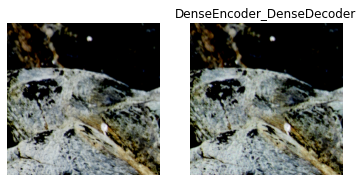

In [20]:
# to see one image
cover,*rest = next(iter(valid_set))
_, H, W = cover.size()
cover = cover[None].to(device)
text = "We are busy in Neural Networks project. Anyhow, how is your day going?"
payload = make_payload(W, H, data_depth, text)
payload = payload.to(device)
#generated = encoder.forward(cover, payload)
generated = test(encoder,decoder,data_depth,epochs,cover,payload)
text_return = make_message(generated)
print(text_return)

###Testing begins (from a loaded model)

####Test1 - Save steganographic images

In [67]:
##Take all images from test folder (one by one) and message requested by user to encode

from imageio import imread, imwrite
 
epochs = 64
data_depth = 4 
test_folder = "div2k/myval/_"
save_dir = os.mkdir(os.path.join("div2k/myval",str(data_depth)+"_"+str(epochs)))

for filename in os.listdir(test_folder):
    print(os.path.join(test_folder,filename))

    cover_im = imread(os.path.join(test_folder,filename), pilmode='RGB') / 127.5 - 1.0

    cover = torch.FloatTensor(cover_im).permute(2, 1, 0).unsqueeze(0)
    cover_size = cover.size()
    # _, _, height, width = cover.size()
    text = "We are busy in Neural Networks project. The deadline is near. Anyhow, how is your day going?"
    payload = make_payload(cover_size[3], cover_size[2], data_depth, text)

    cover = cover.to(device)
    payload = payload.to(device)
    generated = encoder.forward(cover, payload)[0].clamp(-1.0, 1.0)
    #print(generated.size())
    generated = (generated.permute(2, 1, 0).detach().cpu().numpy() + 1.0) * 127.5

    imwrite(os.path.join("div2k/myval/",str(data_depth)+"_"+str(epochs),(str(data_depth)+"_"+str(epochs)+"_"+filename)), generated.astype('uint8'))

div2k/myval/_/0805.png
div2k/myval/_/0804.png
div2k/myval/_/0833.png
div2k/myval/_/0855.png
div2k/myval/_/0874.png
div2k/myval/_/0894.png


####Test2 - Take a steganographic image from a folder and decode

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Too many (or few) errors found by Chien Search for the errata locator polynomial!
Too many (or few) errors found by Chien Search for the errata locator polynomial!
Too many (or few) errors found by Chien Search for the errata locator polynomial!
We are busy in Neural Networks project. The deadline is near. Anyhow, how is your day going?


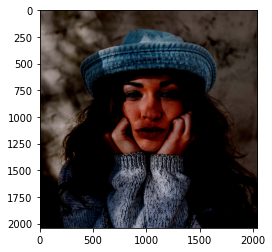

In [69]:
##[Individual]Take an image requested by user to decode

from imageio import imread, imwrite

steg_folder = "div2k/myval/4_64"
filename = "4_64_0855.png"
image = imread(os.path.join(steg_folder,filename), pilmode='RGB') / 127.5 - 1.0
plt.imshow(image)
image = torch.FloatTensor(image).permute(2, 1, 0).unsqueeze(0)
text_return = make_message(image)
print(text_return)
#f = open(steg_folder+".csv", "a")
#f.write("\n" + filename + "\t" + str(text_return))

####Test3 - Encode to decode in one cell

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Too many (or few) errors found by Chien Search for the errata locator polynomial!
Too many (or few) errors found by Chien Search for the errata locator polynomial!
Too many (or few) errors found by Chien Search for the errata locator polynomial!
Too many (or few) errors found by Chien Search for the errata locator polynomial!
We are busy in Neural Networks project. Anyhow, how is your day going?


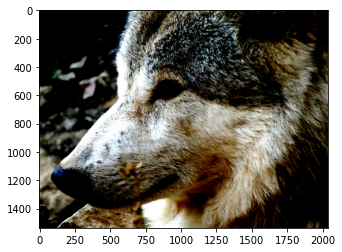

In [21]:
##Input to outut (both encode decode in one cell)
from imageio import imread, imwrite

cover_im = imread("div2k/myval/_/0805.png", pilmode='RGB') / 127.5 - 1.0
plt.imshow(cover_im)
cover = torch.FloatTensor(cover_im).permute(2, 1, 0).unsqueeze(0)
cover_size = cover.size()
# _, _, height, width = cover.size()
text = "We are busy in Neural Networks project. Anyhow, how is your day going?"
payload = make_payload(cover_size[3], cover_size[2], data_depth, text)

cover = cover.to(device)
payload = payload.to(device)
generated = encoder.forward(cover, payload)
text_return = make_message(generated)
print(text_return)

####Generate Difference Image

In [70]:
from skimage.metrics import structural_similarity as ssim
from imageio import imread, imwrite

diff_epochs = 64
diff_data_depth = 4
cover_folder = "div2k/myval/_"
steg_folder = "div2k/myval/"+str(diff_data_depth)+"_"+str(diff_epochs)

for filename in os.listdir(cover_folder):
    print(os.path.join(cover_folder,filename))

    cover = imread(os.path.join(cover_folder,filename), as_gray=True) 
    gen = imread(os.path.join(steg_folder,str(diff_data_depth)+"_"+str(diff_epochs)+"_"+filename), as_gray=True)

    (score, diff) = ssim(cover, gen, full=True)
    imwrite("div2k/myval/"+str(diff_data_depth)+"_"+str(diff_epochs)+"/"+"%d_%d_diff_%s"%(diff_data_depth,diff_epochs,filename),diff)
    print("Score: ",score)

div2k/myval/_/0805.png


Score:  0.9365308093399591
div2k/myval/_/0804.png


Score:  0.8902719298260239
div2k/myval/_/0833.png


Score:  0.8162515821785961
div2k/myval/_/0855.png


Score:  0.934201704783156
div2k/myval/_/0874.png


Score:  0.8543887343320956
div2k/myval/_/0894.png


Score:  0.7241649693633152
